# Compare Fixpoints found by different methods
----

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import yaml

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Running on {}!'.format(device))

Running on cpu!


In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [5]:
methods = ['graph_optimization','newton_method','broyden_method']

### Graph Classification Dataset

In [6]:
datasets_graph = ['proteins','mutag','enzymes','imdb-multi']

In [19]:
# read data from file
H_graph = []
for dataset in datasets_graph:
    for method in methods:
        path = '../src/outputs/H_tu_' + dataset + '_' + method + '.pkl'
        file = os.path.join(os.getcwd(), path)
        h = torch.load(file,map_location=device)
        H_graph.append(h)

********** proteins **********
proteins:Intermediate result of graph_optimization! Result for 195 graphs available.


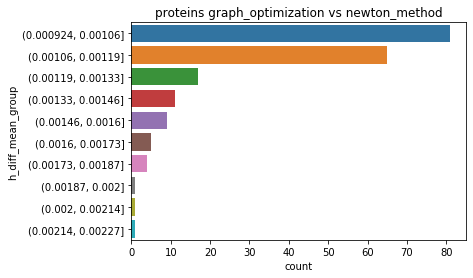

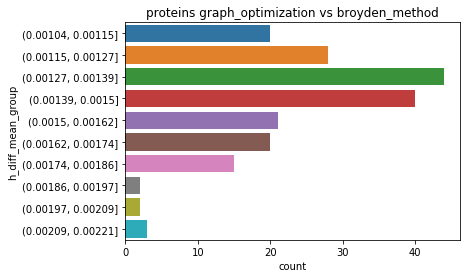

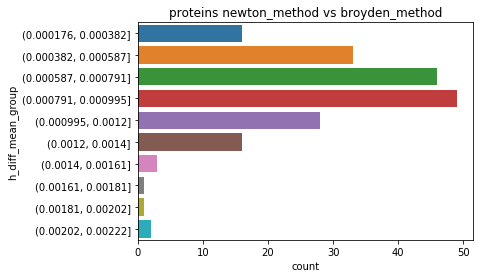

********** mutag **********
All methods successfully finished!


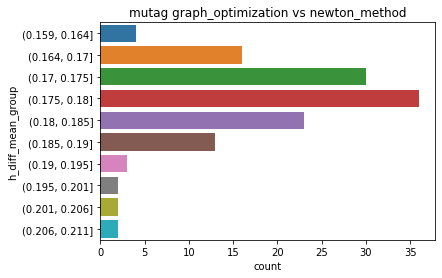

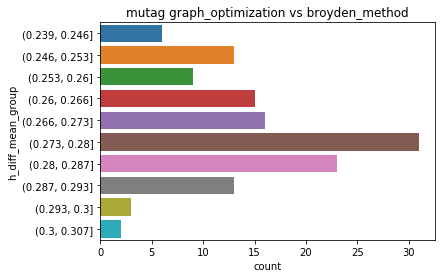

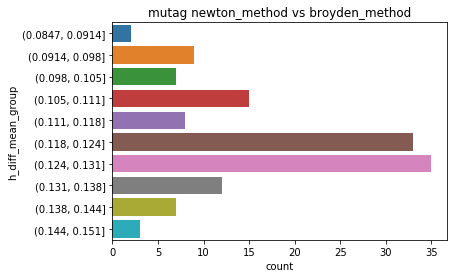

********** enzymes **********
enzymes:Intermediate result of graph_optimization! Result for 97 graphs available.
enzymes:Intermediate result of newton_method! Result for 115 graphs available.


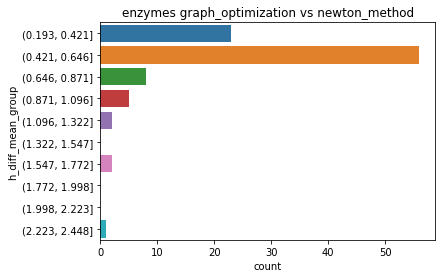

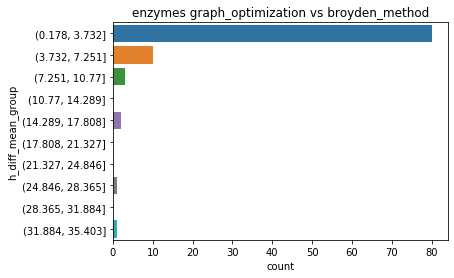

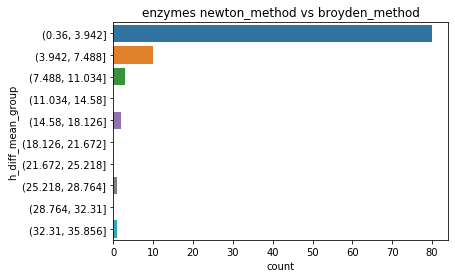

********** imdb-multi **********
imdb-multi:Intermediate result of graph_optimization! Result for 111 graphs available.
imdb-multi:Intermediate result of newton_method! Result for 300 graphs available.
imdb-multi:Intermediate result of broyden_method! Result for 300 graphs available.


RuntimeError: The size of tensor a (16) must match the size of tensor b (12) at non-singleton dimension 0

In [20]:
for i in np.arange(len(H_graph)):
    if i % len(methods) == 0:
        dataset_num = int(i/len(methods))
        dataset_name = datasets_graph[dataset_num]
        print('********** '+dataset_name+' **********')
        
        # check if result is saved before return to main
        config_path = '../src/configs/tu_' + dataset_name + '.yaml'
        config_file = os.path.join(os.getcwd(), config_path)
        with open(config_file, 'r') as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
        training_set_len = int(config['dataset_len'] * config['train_ratio'])
        length = training_set_len
        for j in np.arange(len(methods)):
            if len(H_graph[i+j])<training_set_len:
                print("{}:Intermediate result of {}! Result for {} graphs available.".format(dataset_name,methods[j],len(H_graph[i+j])))
                length = min(length,len(H_graph[i+j]))
        if length==training_set_len:
            print("All methods successfully finished!")
            
        for j in np.arange(len(methods)):
            H_graph[i+j] = H_graph[i+j][:length]
    
        # calculate and plot difference between different methods
        for m in np.arange(len(methods)):
            for n in np.arange(len(methods)):
                if n>m:
                    h_diff_mean = np.zeros(length)
                    for l in np.arange(length):
                        h_diff_mean[l] = torch.mean(torch.abs(H_graph[i+m][l]-H_graph[i+n][l])).numpy()
                        df_h_diff = pd.DataFrame({'graph_id': np.arange(length),
                                                'h_diff_mean': h_diff_mean})
                    
                    df_h_diff['h_diff_mean_group'] = pd.cut(df_h_diff['h_diff_mean'],10)
                    plt.title(dataset_name+' '+ methods[m]+' vs '+ methods[n])
                    sns.countplot(y = 'h_diff_mean_group', data = df_h_diff)
                    plt.show()

********** proteins **********


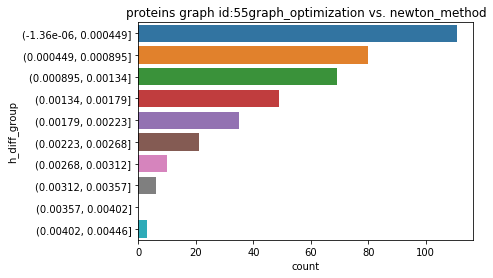

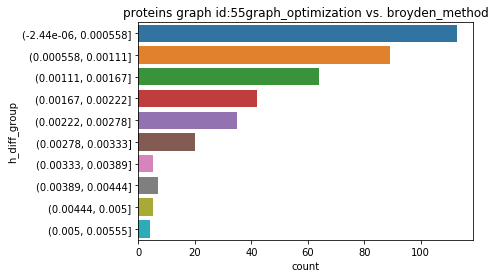

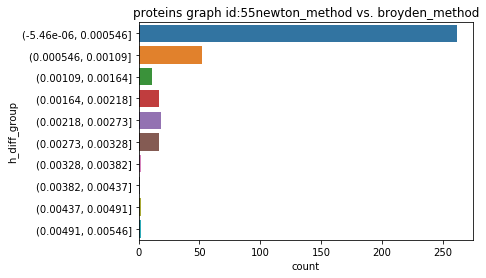

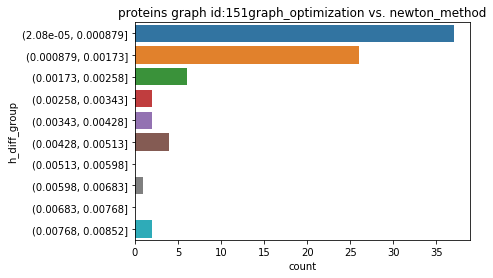

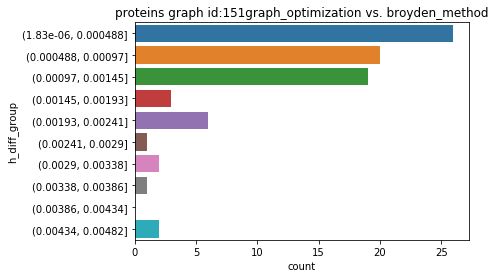

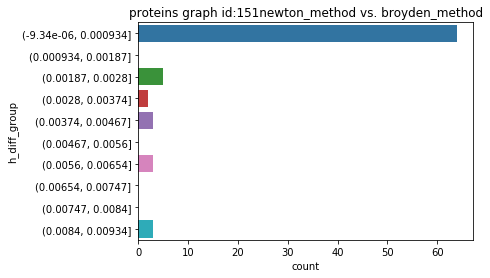

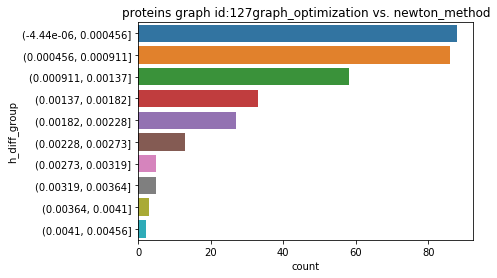

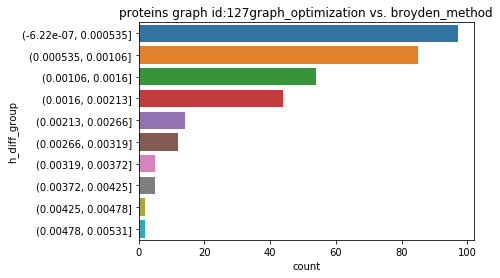

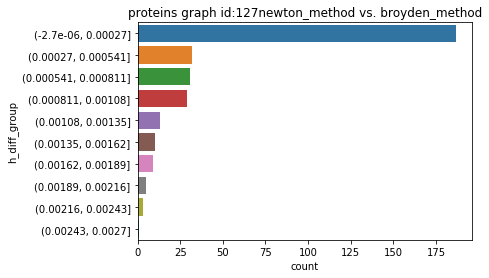

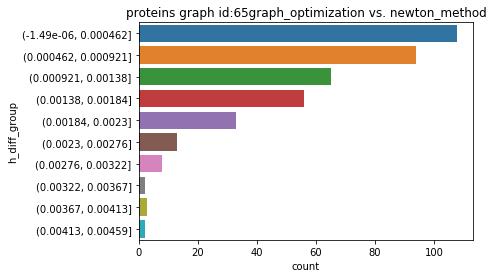

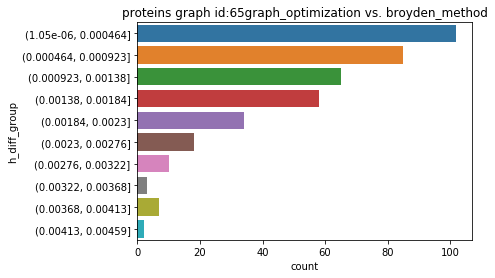

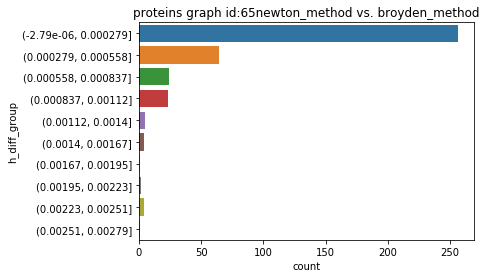

********** mutag **********


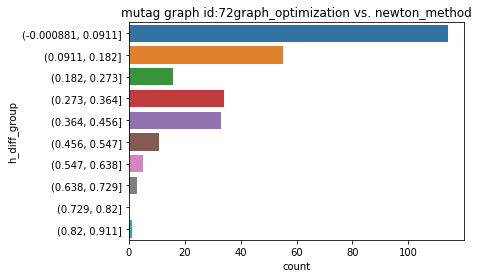

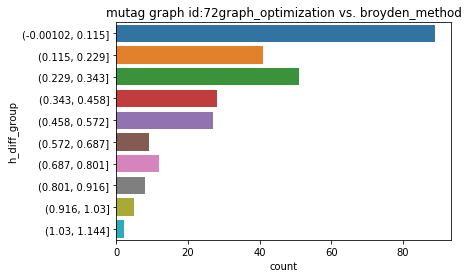

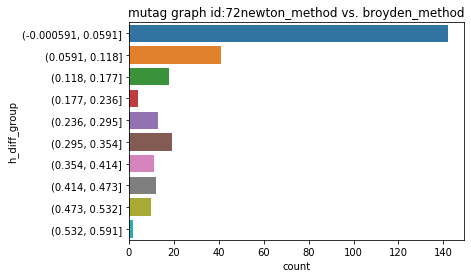

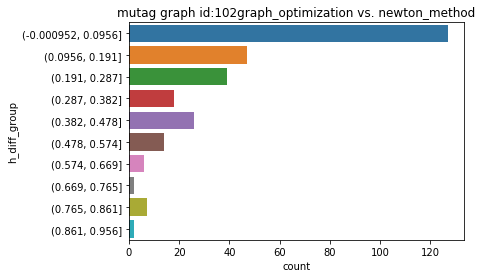

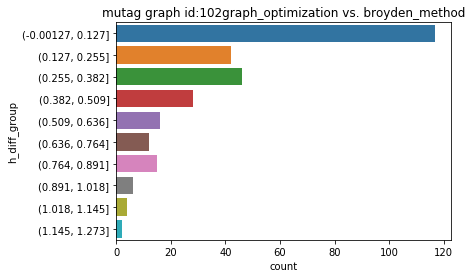

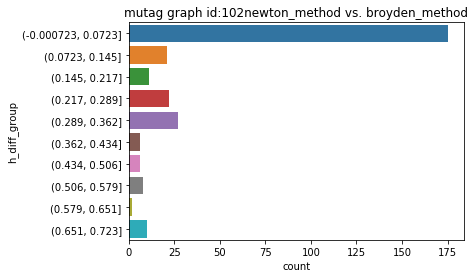

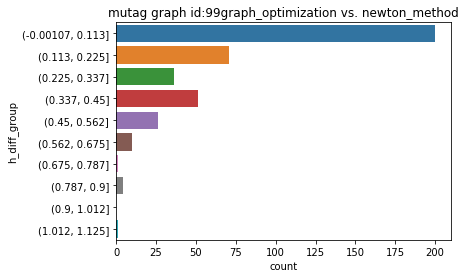

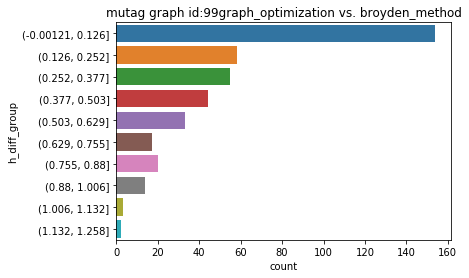

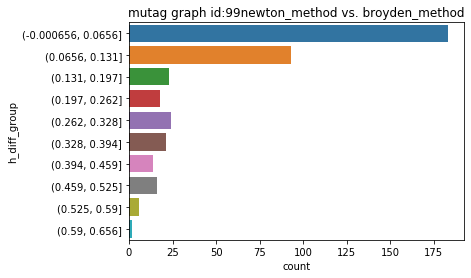

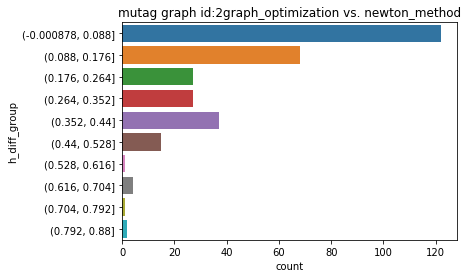

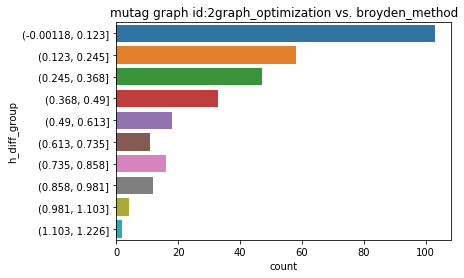

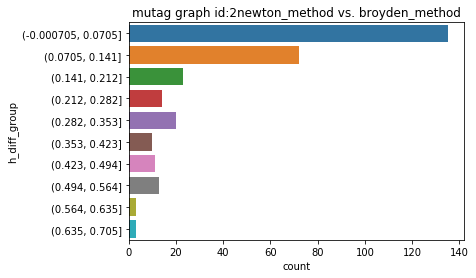

********** enzymes **********


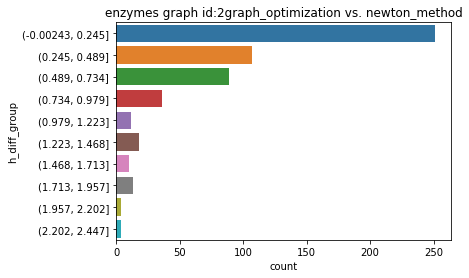

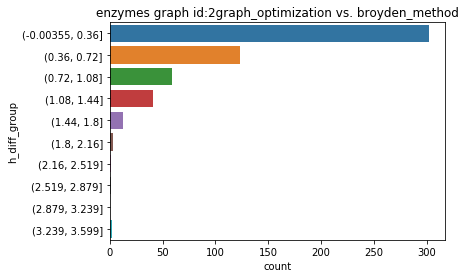

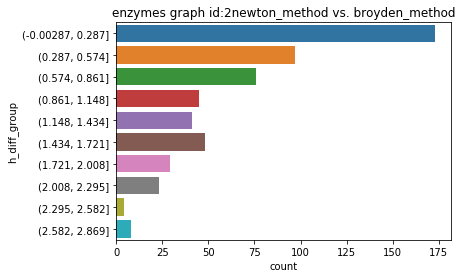

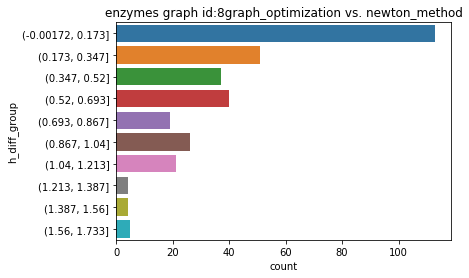

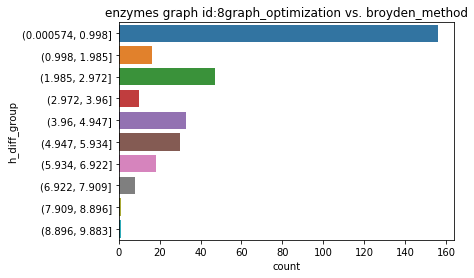

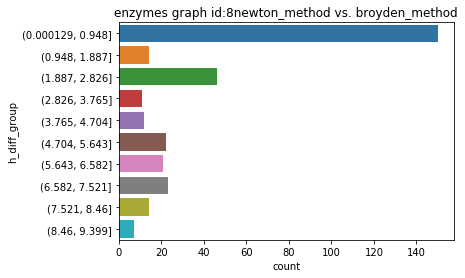

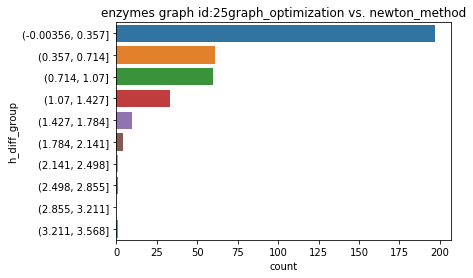

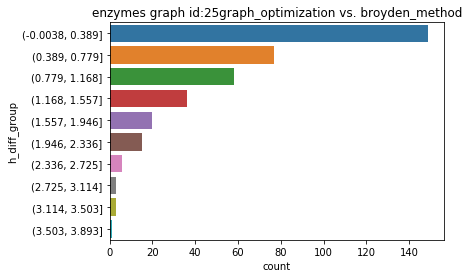

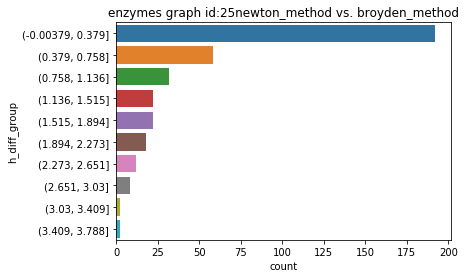

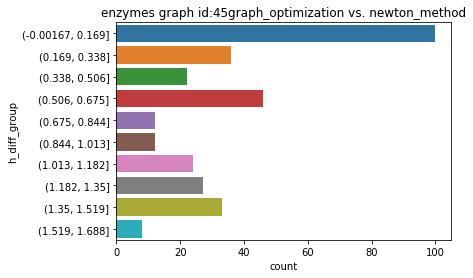

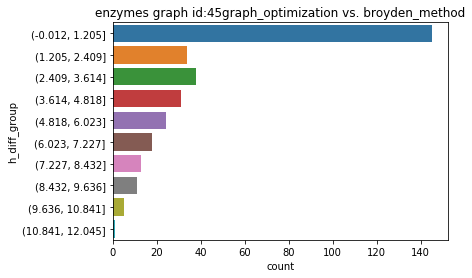

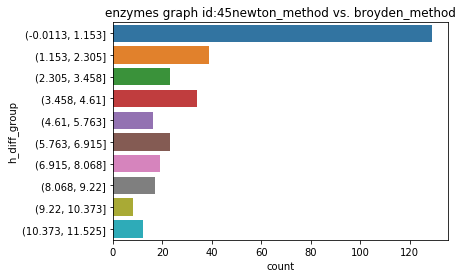

********** imdb-multi **********


RuntimeError: The size of tensor a (7) must match the size of tensor b (9) at non-singleton dimension 0

In [28]:
num = 4 # how many graphs should be picked randomly 
# compare H of randomly picked graphs from dataset
for i in np.arange(len(H_graph)):
    if i % len(methods) == 0:
        dataset_num = int(i/len(methods))
        dataset_name = datasets_graph[dataset_num]
        print('********** '+dataset_name+' **********')
        length = len(H_graph[i])
        
        for j in np.random.randint(0, length, num):
            for m in np.arange(len(methods)):
                for n in np.arange(len(methods)):
                    if n>m:
                        h_diff = (torch.abs(H_graph[i+m][j]-H_graph[i+n][j])).numpy().flatten()
                        df_h_diff = pd.DataFrame({'feature_id': np.arange(len(h_diff)),
                                                    'h_diff': h_diff})
                        df_h_diff['h_diff_group'] = pd.cut(df_h_diff['h_diff'],10)
                        plt.title(dataset_name + ' graph id:' + str(j)+ methods[m]+' vs. '+methods[n] )
                        sns.countplot(y = 'h_diff_group', data = df_h_diff)
                        plt.show()